# Convergence of the error
In this notebook, we test the theoretical orders of convergence for the Poisson problem
$$
\begin{aligned}
-\Delta u &= f \quad\text{in }\Omega\\
u &= g_D \quad\text{on }\Gamma_D\\
\nabla u\cdot n &= g_N \quad\text{on }\Gamma_N.
\end{aligned}
$$
Given a mesh with characteristic element size $h$ and a FE space of piecewise polynomial functions of degree $p$, we expect that the error between the FE solution $u_h$ and the exact one $u$ behaves as follows: there exists a constant $C>0$ such that
$$
\left(\int_\Omega (u-u_h)^2 \right)^{1/2}\leq C h^{p+1}
$$
and 
$$
\left(\int_\Omega (\nabla u-\nabla u_h)^2\right)^{1/2} \leq C h^{p}.
$$
The two bounds above are true  *provided that the function $u$ has at least $p+1$ square-integrable derivatives* (i.e., that the function is sufficiently regular), *otherwise the order of convergence is reduced*. 

The first is called the $L^2$ norm of the error, while the second one is the $H^1_0$ (or energy) norm.

We consider the case where the exact solution is not known: look at the notebook where the order of convergence is computed for manifactured solutions before reading this one. 

Here, we set $f=1$, $\Gamma_D = \partial \Omega$, and $\Omega = (0,1)^2$. We compute the solution on a FE space with many degrees of freedom and we use that solution as our "exact" (reference) solution, computing different the convergence of solutions computed with less degrees of freedom against that one.

In [2]:
from mpi4py import MPI
from petsc4py.PETSc import ScalarType

In [3]:
import numpy as np

import ufl
from dolfinx import fem, io, mesh, plot 
from dolfinx.fem import Expression, Function, form, assemble_scalar
from dolfinx.fem.petsc import LinearProblem
from ufl import ds, dx, grad, inner
import matplotlib.pyplot as plt
import pandas as pd


After the imports, we create a function that solves the Poisson problem, as in the other notebooks. It takes as an input the number of refinements per edge of the domain and the polynomial degree. 

In [4]:
def solve_problem(n_el, p):
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((0., 0), (1.0, 1.0)),
        n=[n_el]*2,
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", p))
    facets = mesh.locate_entities_boundary(
        msh,
        dim=(msh.topology.dim - 1),
        marker=lambda x: np.isclose(x[0], 0) | np.isclose(x[0], 1) | np.isclose(x[1], 0) | np.isclose(x[1], 1.),
    )
    dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)
    bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    x = ufl.SpatialCoordinate(msh)
    f = ScalarType(1)

    a = inner(grad(u), grad(v)) * dx
    L = inner(f, v) * dx 
    problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    uh = problem.solve()

    return uh


We compute the reference solution.

In [5]:
uref = solve_problem(100, 6)

We will need an interpolate function, that we will use to compare solutions computed on different grids and different FE spaces. This will be necessary to compare the $u_h$ we will compute with the $u_{\mathrm{ref}}$ we have just computed.

In [6]:
def interpolate(u1,
                u2
                ):
    '''
    Interpolate u1 to u2,
    each comming from separate meshes
    '''
    rmesh = u2.function_space.mesh
    rtopology = rmesh.topology
    cmap = rtopology.index_map(rtopology.dim)
    num_cells = cmap.size_local + cmap.num_ghosts
    all_cells = np.arange(num_cells,dtype=np.int32)
    nmmid_all = fem.create_interpolation_data(
                                 u2.function_space,
                                 u1.function_space,
                                 all_cells,
                                 padding=0,)
    u2.interpolate_nonmatching(u1, cells=all_cells, interpolation_data=nmmid_all)


We now write two functions that compute the two types of the error between $u_h$ and $u_{\mathrm{ref}}$, that we have defined above. Compared to the other notebook, this functions are more complex because we have to project the solution $u_h$ on the space associated with $u_{\mathrm{ref}}$.

In [7]:
def L2_error(uh, u_ref):
    Vref = u_ref.function_space
    uh_Vref = Function(Vref)
    interpolate(uh, uh_Vref)

    e_Vref = Function(Vref)
    e_Vref.x.array[:] = uh_Vref.x.array - u_ref.x.array 
    error = form(e_Vref**2 * ufl.dx)

    E = np.sqrt(assemble_scalar(error))
    return E

def H1_error(uh, u_ref):
    Vref = u_ref.function_space
    uh_Vref = Function(Vref)
    interpolate(uh, uh_Vref)

    e_Vref = Function(Vref)
    e_Vref.x.array[:] = uh_Vref.x.array - u_ref.x.array 

    error = form(ufl.grad(e_Vref)**2 * ufl.dx)
    E = np.sqrt(assemble_scalar(error))
    return E


We then compute the errors, for different grid sizes and for a fixed polynomial degree, here $p=1$. We consider different grids, starting with 4 elements per side of the domain, and adding 10 elements per side at each refinement. 

In [8]:
p = 1
Ns = range(4, 104, 10)
L2err = np.zeros(len(Ns))
H1err = np.zeros(len(Ns))
h = np.zeros(len(Ns))

for i, n in enumerate(Ns):
    uh = solve_problem(n, p)

    L2err[i] = L2_error(uh, uref)
    H1err[i] = H1_error(uh, uref)
    h[i] = 1./n

We now want to plot the behaviour of the errors with respect to the grid size. We start by doing this on a linear-linear plot. We invert the ordinate axis to show the error going down for smaller mesh sizes.

Text(0.5, 0, '$h$')

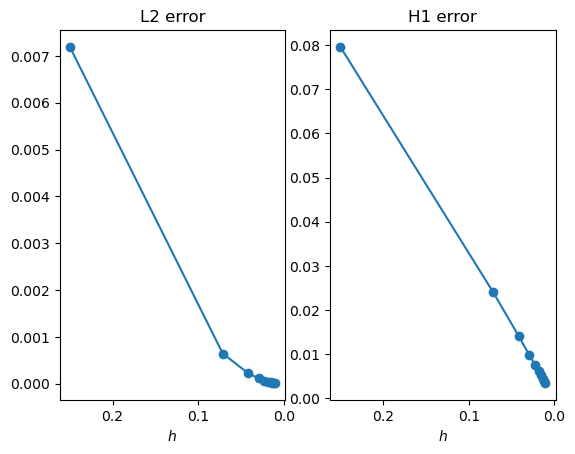

In [9]:
_, ax = plt.subplots(1, 2)
ax[0].plot(h, L2err, '-o')
ax[0].invert_xaxis()
ax[0].set_title('L2 error')
ax[0].set_xlabel('$h$')
ax[1].plot(h, H1err, '-o')
ax[1].invert_xaxis()
ax[1].set_title('H1 error')
ax[1].set_xlabel('$h$')

In the plot above, it is hard to properly see the rate of convergence. We redo the plot in the $\log-\log$ scale.

Text(0.5, 0, '$h$')

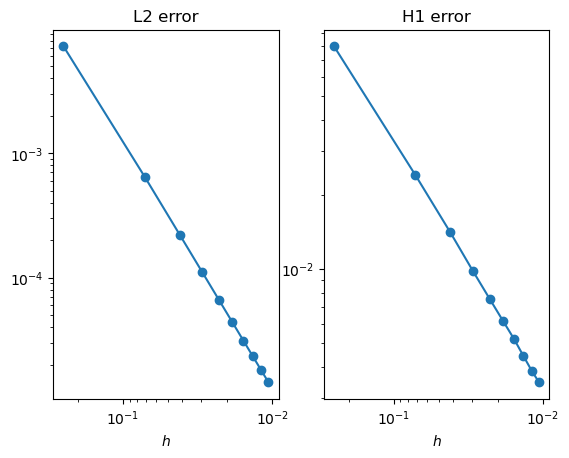

In [10]:
_, ax = plt.subplots(1, 2)
ax[0].loglog(h, L2err, '-o')
ax[0].invert_xaxis()
ax[0].set_title('L2 error')
ax[0].set_xlabel('$h$')
ax[1].loglog(h, H1err, '-o')
ax[1].invert_xaxis()
ax[1].set_title('H1 error')
ax[1].set_xlabel('$h$')

We now exploit the fact that, if, for some $C, r>0$ independent of $h$
$$ 
\mathrm{e}(h) = C h^{r}
$$
then 
$$
\log(e(h)) = \log(C) + r \log(h),
$$
which implies that an error curve will show up as a line with slope $r$ in $\log-\log$ scale. We first estimate our computational orders of convergence: we don't know the value of $C$, but we have that, if the equation above for the error is satisfied, for two values $h_i, h_j$,
$$
\log(e(h_i)) - \log(e(h_j)) = r \left[\log(h_i) - \log(h_j)\right].
$$
We use this equation to estimate the value of $r$.

In [11]:
L2r_est = np.divide(np.diff(np.log(L2err)), np.diff(np.log(h)))
H1r_est = np.divide(np.diff(np.log(H1err)), np.diff(np.log(h)))

df = pd.DataFrame({
    "L2 rate": L2r_est, 
    "H1 rate": H1r_est
})
df

,L2 rate,H1 rate
0,1.927832,0.957665
1,1.986941,0.992756
2,1.993986,1.034617
3,1.996547,1.005568
4,1.997479,1.000567
5,1.998985,0.991314
6,1.997517,1.096951
7,1.999289,1.075140
8,1.998396,0.964348


We now plot the theoretical estimate as a straight line alongside the errors that we computed, in the $\log-\log$ scale.

Text(0.5, 0, '$h$')

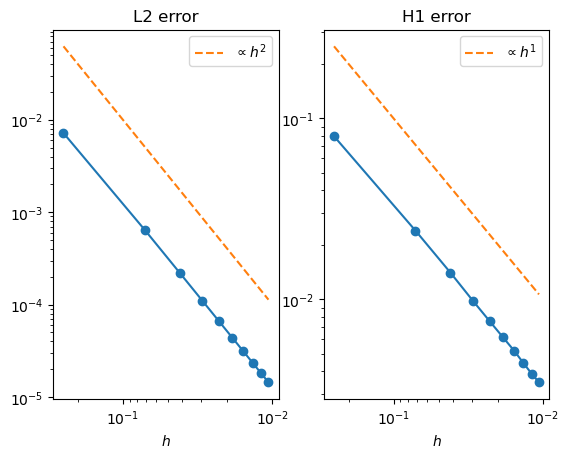

In [12]:
L2th = h**(p+1)
H1th = h**p 
_, ax = plt.subplots(1, 2)
ax[0].loglog(h, L2err, '-o')
ax[0].loglog(h, L2th, '--', label=f"$\propto h^{p+1}$")
ax[0].invert_xaxis()
ax[0].set_title('L2 error')
ax[0].set_xlabel('$h$')
ax[0].legend()
ax[1].loglog(h, H1err, '-o')
ax[1].loglog(h, H1th, '--', label=f"$\propto h^{p}$")
ax[1].invert_xaxis()
ax[1].legend()
ax[1].set_title('H1 error')
ax[1].set_xlabel('$h$')

We now repeat this whole procedure for a different polynomial degree $p=3$.

Text(0.5, 0, '$h$')

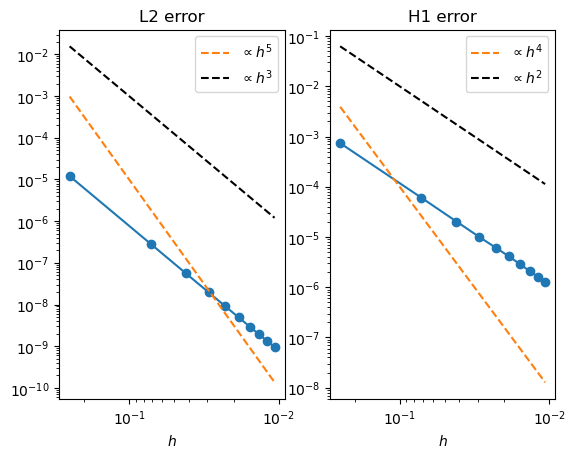

In [15]:
p = 4
Ns = range(4, 104, 10)
L2err = np.zeros(len(Ns))
H1err = np.zeros(len(Ns))
h = np.zeros(len(Ns))

for i, n in enumerate(Ns):
    uh = solve_problem(n, p)

    L2err[i] = L2_error(uh, uref)
    H1err[i] = H1_error(uh, uref)
    h[i] = 1./n

L2th = h**(p+1)
L2th2 = h**(3)
H1th = h**p 
H1th2 = h**2 
_, ax = plt.subplots(1, 2)
ax[0].loglog(h, L2err, '-o')
ax[0].loglog(h, L2th, '--', label=f"$\propto h^{p+1}$")
ax[0].loglog(h, L2th2, 'k--', label=f"$\propto h^{3}$")
ax[0].invert_xaxis()
ax[0].set_title('L2 error')
ax[0].set_xlabel('$h$')
ax[0].legend()
ax[1].loglog(h, H1err, '-o')
ax[1].loglog(h, H1th, '--', label=f"$\propto h^{p}$")
ax[1].loglog(h, H1th2, 'k--', label=f"$\propto h^{2}$")
ax[1].invert_xaxis()
ax[1].legend()
ax[1].set_title('H1 error')
ax[1].set_xlabel('$h$')

In [16]:
L2r_est = np.divide(np.diff(np.log(L2err)), np.diff(np.log(h)))
H1r_est = np.divide(np.diff(np.log(H1err)), np.diff(np.log(h)))

df = pd.DataFrame({
    "L2 rate": L2r_est, 
    "H1 rate": H1r_est
})
df

,L2 rate,H1 rate
0,2.998327,1.999187
1,3.000600,2.017677
2,2.997786,2.013955
3,2.994208,1.943235
4,2.995913,1.955775
5,2.967266,2.096705
6,3.016545,2.143421
7,2.879105,1.979640
8,2.981346,2.105676


We can observe that in this domain, we do not see the "expected" order of convergence. This is due to the fact that the domain has corners, and the exact solution does not have, therefore, the required regularity for that rate to be observed.